## Setup

In [0]:
%load_ext autoreload
%autoreload 2

In [3]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'nmf'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/nmf


In [0]:
from torch.utils.data import DataLoader
import my_layers
import utils
import numpy as np
from sklearn.decomposition import NMF
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data.dataset import random_split
import torch

In [0]:
# Data Loading
M = np.load('synthetic_data/x.syn.many.types.0.5_sp.sp.npy')
X = M.T

In [0]:
#params
n_components = 7 # check the tructh rank from table
samples, features = X.shape 

In [0]:
#split train/test
TRAIN_SIZE = 0.80
mask = np.random.rand(samples) < TRAIN_SIZE

X_train = X[mask]  
X_test = X[~mask] 

In [8]:
# MU building target labels for training using Scikit NMF
nmf = NMF(n_components=n_components, solver='mu', beta_loss='frobenius', verbose=True)
W_train = nmf.fit_transform(X_train)
H = nmf.components_

Epoch 10 reached after 0.009 seconds, error: 48281.588311
Epoch 20 reached after 0.015 seconds, error: 48114.491646
Epoch 30 reached after 0.021 seconds, error: 48090.610563
Epoch 40 reached after 0.028 seconds, error: 48079.925263


In [9]:
W_test = nmf.transform(X_test)

Epoch 10 reached after 0.001 seconds, error: 18851.298362
Epoch 20 reached after 0.002 seconds, error: 18730.218386
Epoch 30 reached after 0.003 seconds, error: 18716.382460
Epoch 40 reached after 0.004 seconds, error: 18712.903254


#### initialize exposures



In [0]:
W0_train = utils.initialize_transformed(X_train, n_components)
W0_test = utils.initialize_transformed(X_test, n_components) # might be per sample or include the whole X ??

#### Tensoring the Arrays

In [0]:
X_train_tensor = torch.from_numpy(X_train).float()
W_train_tensor = torch.from_numpy(W_train).float()
W0_train_tensor = torch.from_numpy(W0_train).float()

X_test_tensor = torch.from_numpy(X_test).float()
W_test_tensor = torch.from_numpy(W_test).float()
W0_test_tensor = torch.from_numpy(W0_test).float()

## Basic Model
5 layers with non-negative constrains on weights

Trained with Graident decent

### Training The Network

In [0]:
from my_layers import *
constraints = utils.WeightClipper()
deep_nmf_5 = NMFModel_1(n_components, features)
deep_nmf_5.apply(constraints)
criterion = nn.MSELoss()
optimizerSGD = optim.SGD(deep_nmf_5.parameters(), lr=1e-4)
optimizerADAM = optim.Adam(deep_nmf_5.parameters(), lr=1e-4)

In [0]:
inputs = (W0_train_tensor, X_train_tensor)
loss_values = []
for i in range(5000):

    out = deep_nmf_5(*inputs)
    loss = criterion(out, W_train_tensor)
    print(i, loss.item())

    optimizerADAM.zero_grad()
    loss.backward()
    optimizerADAM.step()

    deep_nmf_5.apply(constraints) # keep wieghts positive
    loss_values.append(loss.item())

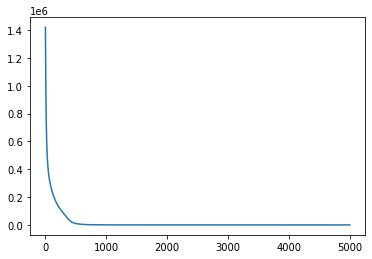

In [14]:
from matplotlib import pyplot as plt
plt.plot(loss_values)

### Compare with Test Data
comparison is on the reconstruction Error

In [0]:
test_inputs = (W0_test_tensor, X_test_tensor)
netwrok_prediction = deep_nmf_5(*test_inputs)

In [16]:
network_error = utils.frobinuis_reconstruct_error(X_test_tensor, netwrok_prediction, H)
print('deep NMF Error: ', network_error)

deep NMF Error:  85171.45361364844


In [17]:
mu_error = utils.frobinuis_reconstruct_error(X_test_tensor, W_test_tensor, H)
print('regular MU Error: ', mu_error)

regular MU Error:  18712.903253616965
